# Intermittency Analysis
- Figure 6

In [263]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.sparse import csgraph
from meshparty import skeleton_io
from scipy.sparse.csgraph import shortest_path

import statsmodels.api as sm
from scipy.stats import pearsonr, percentileofscore

%matplotlib inline

## Functions

In [33]:
def distance(x, y):
    
    return np.sqrt(np.sum((x-y)**2, axis=1))


def str2coord(str_coord, dtype="int"):
    
    l = str_coord[1:-1].split(" ")
    coord = []
    for j in range(len(l)):
        if l[j] != "":
            if dtype == "int": 
                coord.append(int(l[j]))
            elif dtype == "float":
                coord.append(float(l[j]))
    
    coord = np.array(coord)
    
    return coord

In [237]:
fs = 18

def plot_trace_dir(ax, seg_id, angle, xlab="", ylab=""):
    
    scan_id = int(scan_list[pyc_func_list==seg_id])

    trace = RawTrace[seg_id]
    spike = Spike[seg_id]
    stimlab = StimulusLabel["scan{}".format(scan_id)]

    section_list = get_section(stimlab, angle)

    for s in section_list:
        n = s[1] - s[0] + 1
        plt.plot(np.arange(0,n*0.0674-0.001,0.0674), trace[s[0]:s[1]+1], linewidth=0.5)

    ax.set_xlim(0,1)
    ax.set_xticks(np.arange(0,1.1,0.5))
    ax.set_xticklabels(np.round(ax.get_xticks(),1), fontsize=15, fontname="Helvetica")
    ax.set_yticklabels(ax.get_yticks().astype("int"), fontsize=15, fontname="Helvetica")
    ax.set_xlabel(xlab, fontsize=fs, fontname="Helvetica")
    ax.set_ylabel(ylab, fontsize=fs, fontname="Helvetica")
    
    
def plot_linfit(ax, xval, yval, xlab="Intermittency", ylab="In-connection density ($\mu m^{-1}$)"):
    
    Xval = sm.add_constant(xval)
    re = sm.OLS(yval, Xval).fit()

    xrng = np.max(xval) - np.min(xval)
    xlin = np.linspace(np.min(xval)-0.01*xrng,np.max(xval)+0.01*xrng,100)
    Xlin = sm.add_constant(xlin)
    dt = re.get_prediction(Xlin).summary_frame(alpha = 0.2)

    palette = sns.color_palette("colorblind")
    ax.plot(xval, yval, 'k.', alpha=0.2)
    ax.plot(xlin, dt["mean"], '-', alpha=0.8)
    ax.fill_between(
        xlin, dt["obs_ci_lower"], dt["obs_ci_upper"],
        alpha=0.2, color="gray")
    ax.set_xlabel(xlab, fontsize=fs, fontname="Helvetica")
    ax.set_ylabel(ylab, fontsize=fs, fontname="Helvetica")

## All PyC

In [13]:
cell_info = pd.read_csv("data/cell_info.csv")

pyc_list = cell_info["segment_id"]
n_pyc = pyc_list.shape[0]

cell_info

,segment_id,soma_loc
0,648518346349491311,[314.028 159.94 77.28 ]
1,648518346349492130,[291.484 145.484 80.96 ]
2,648518346349492197,[270.948 158.088 86.24 ]
3,648518346349492682,[461.372 212.624 27.64 ]
4,648518346349493472,[431.864 156.576 85.72 ]
...,...,...
358,648518346349540048,[349.132 163.492 11.48 ]
359,648518346349540051,[444.892 247.424 47.48 ]
360,648518346349540053,[446.104 253.936 18.32 ]
361,648518346349540055,[340.468 248.332 23.4 ]


In [36]:
pyc_soma_loc = np.zeros((n_pyc, 3))
for i in range(n_pyc):
    pyc_soma_loc[i,:] = str2coord(cell_info["soma_loc"][i], dtype="float")

## PyC with functional data

In [168]:
cell_info_func = pd.read_csv("data/cell_functional_info.csv")

pyc_func_list = np.array(cell_info_func["segment_id"])
scan_list = np.array(cell_info_func["scan"])
n_func = pyc_func_list.shape[0]

osi_p = np.array(cell_info_func["osi_p"])
dsi_p = np.array(cell_info_func["dsi_p"])

tune_os_idx = osi_p<0.05
tune_ds_idx = dsi_p<0.05
tune_all_idx = tune_os_idx + tune_ds_idx

seg_id_os = pyc_func_list[tune_os_idx]
seg_id_ds = pyc_func_list[tune_ds_idx]
seg_id_tuned = pyc_func_list[tune_all_idx]

cell_info_func

,segment_id,scan,osi,osi_p,dsi,dsi_p
0,648518346349539895,1,1.399790,0.0085,0.360205,0.9077
1,648518346349537860,1,1.791797,0.0000,0.379977,0.7241
2,648518346349538440,1,1.369347,0.0025,0.257158,0.9983
3,648518346349538527,1,1.021334,0.0276,0.972555,0.9746
4,648518346349538209,1,1.863632,0.0000,0.100173,0.9763
...,...,...,...,...,...,...
107,648518346349537741,5,1.266736,0.0568,0.528219,0.9732
108,648518346349537901,5,1.163586,0.1148,1.162096,0.1404
109,648518346349538001,5,1.321359,0.0631,1.324058,0.0638
110,648518346349538251,5,1.436740,0.0139,1.399342,0.0287


In [6]:
f_rawtrace = open("data/trace_raw.pkl","rb")
RawTrace = pickle.load(f_rawtrace)
f_rawtrace.close()

f_trace = open("data/trace.pkl", "rb")
Trace = pickle.load(f_trace)
f_trace.close()

f_spike = open("data/spike.pkl", "rb")
Spike = pickle.load(f_spike)
f_spike.close()

f_stim_lab = open("data/stimulus_label.pkl", "rb")
StimulusLabel = pickle.load(f_stim_lab)
f_stim_lab.close()

In [268]:
pyc_func_soma_loc = np.zeros((n_func, 3))
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    idx = np.where(pyc_list==seg_id)[0][0]
    pyc_func_soma_loc[i,:] = str2coord(cell_info["soma_loc"][idx], dtype="float")

## PyC - PyC subgraph
- Pyramidal cells that have cell bodies in our volume.
- Connections among pyramidal cells

In [7]:
synapse_pyc_df = pd.read_csv("data/pyc_pyc_subgraph.csv")
synapse_pyc_df

,segmentation,id,valid,pre_pt_position,pre_pt_supervoxel_id,pre_pt_root_id,ctr_pt_position,post_pt_position,post_pt_supervoxel_id,post_pt_root_id,size,spine_vol,exclude_conn
0,185,1484,1,[91332 57836 1584],97170491155950710,648518346349539437,[91369 57798 1582],[91332 57748 1584],97170491155951077,648518346349531254,798,0.133004,0
1,185,2254,1,[64762 45414 711],89838917557174822,648518346349537978,[64742 45419 708],[64720 45430 708],89838917557173796,648518346349537300,129,0.016346,0
2,185,3785,1,[69646 63086 721],91264984138384361,648518346349533058,[69604 63106 721],[69558 63120 721],90983509161691227,648518346349538715,62,0.020969,0
3,185,3863,1,[66776 39946 1138],90396382837344883,648518346349539333,[66750 39982 1139],[66722 39990 1139],90396382837366381,648518346349539806,62,0.018033,0
4,185,4062,1,[89112 48970 2154],96597662777759466,648518346349523975,[89162 48958 2154],[89198 48936 2154],96597662777759456,648518346349537716,62,0.008805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,185,3546372,1,[76660 54312 1086],92945050790541263,648518346349539803,[76699 54305 1090],[76708 54262 1088],92943951278915237,648518346349538239,130,0.044672,0
1964,185,3548009,1,[94662 61228 453],98018175966264919,648518346349531254,[94712 61234 453],[94728 61228 453],98018175966265405,648518346349534360,61,0.023423,0
1965,185,3549101,1,[110936 59500 1362],102520706146780107,648518346349537716,[110994 59494 1363],[111032 59498 1362],102520706146780799,648518346349539896,61,0.016121,0
1966,185,3549680,1,[89680 50944 1475],96599840326171296,648518346349539437,[89706 50906 1474],[89718 50884 1473],96599840326170447,648518346349539781,61,0.021125,0


## Compute dendrite length
- Unit: [$\mu$m]

In [17]:
d_skel = "data/smoothed_skeletons_v185/"

# Calculate dendrite length
dendrite_len = np.zeros((n_pyc,)) # In microns
for i in range(n_pyc):
    
    seg_id = pyc_list[i]
    seg_lab = np.load(d_skel+str(seg_id)+"_skeleton_label.npy")
    seg_skel = skeleton_io.read_skeleton_h5(d_skel+str(seg_id)+"_skeleton.h5")
    
    g = seg_skel.csgraph
    dend_idx = np.where((seg_lab==2)+(seg_lab==3)+(seg_lab==4))[0]
    g = g[dend_idx][:,dend_idx]
    
    dendrite_len[i] = np.sum(g)/1000

In [18]:
dendrite_len_func = np.zeros(n_func)
for i in range(n_func):
    seg_id = pyc_func_list[i]
    dendrite_len_func[i] = dendrite_len[pyc_list==seg_id] 

## Compute in-connection density

In [19]:
pre_id_all = synapse_pyc_df["pre_pt_root_id"]
post_id_all = synapse_pyc_df["post_pt_root_id"]
real_synapse = np.zeros((pre_id_all.shape[0],2), dtype=np.uint64)
real_synapse[:,0] = pre_id_all
real_synapse[:,1] = post_id_all
real_connection = np.unique(real_synapse, axis=0)

In [23]:
# In/out degree
# Computing only for cells with functional data
insyn_deg = np.zeros((n_func)) # In-synapse degree
inconn_deg = np.zeros((n_func)) # In-connection degree
outsyn_deg = np.zeros((n_func)) # Out-synapse degree
outconn_deg = np.zeros((n_func)) # Out-connection degree

for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    
    outsyn_deg[i] = np.sum(real_synapse[:,0]==seg_id)
    insyn_deg[i] = np.sum(real_synapse[:,1]==seg_id)
    
    outconn_deg[i] = np.sum(real_connection[:,0]==seg_id)
    inconn_deg[i] = np.sum(real_connection[:,1]==seg_id)

In [24]:
# In-connection density
inconn_density = inconn_deg/dendrite_len_func

## Compute total in-synapse density

- `data/pyc_all_synapse.csv`: All synapses involving pyramidal cells. i.e. All incoming synapses to pyramidal cells and all outgoing synapses from pyramidal cells. 

In [25]:
synapse_all_pyc_df = pd.read_csv("data/pyc_all_synapse.csv")
synapse_all_pyc_df

,Unnamed: 0,id,valid,pre_pt_position,pre_pt_supervoxel_id,pre_pt_root_id,ctr_pt_position,post_pt_position,post_pt_supervoxel_id,post_pt_root_id,size
0,798380,1,True,[54560 41084 1899],87019808398267921,648518346344505885,[54623 41105 1898],[54606 41142 1899],87019808398265812,648518346349537984,127.0
1,884354,2,True,[111618 68848 170],102812038073418275,648518346342561389,[111617 68901 172],[111536 68888 170],102530563096718550,648518346349537380,153.0
2,248,5,True,[99656 73460 1441],99438779349084007,648518346341408101,[99676 73497 1440],[99584 73470 1439],99438779349083054,648518346349507351,112.0
3,10178,6,True,[56020 42658 1566],87302374296654983,648518346349533058,[56024 42669 1562],[55970 42702 1566],87302374296657562,648518346342805464,714.0
4,295400,22,True,[76020 42954 713],92931843766107917,648518346347971764,[76047 42915 709],[75996 42872 712],92931843766107136,648518346349538718,608.0
...,...,...,...,...,...,...,...,...,...,...,...
902304,169242,3556630,True,[78330 55234 2100],93508035103698987,648518346346314910,[78320 55200 2101],[78314 55176 2101],93508035103699504,648518346349538378,61.0
902305,692081,3556632,True,[70760 56782 905],91539870635267659,648518346342798934,[70750 56788 902],[70702 56780 904],91539870635267469,648518346349539856,224.0
902306,538993,3556638,True,[59556 42132 747],88428244138743851,648518346342799568,[59582 42104 747],[59610 42086 747],88428244138743660,648518346349539781,61.0
902307,145593,3556639,True,[59506 42486 778],88428248433693199,648518346345304931,[59570 42510 777],[59606 42526 778],88428248433693419,648518346349538387,61.0


In [37]:
post_id_all = np.array(synapse_all_pyc_df["post_pt_root_id"])
post_idx = np.where(np.isin(post_id_all, pyc_list))[0]

synapse_post_pyc_df = synapse_all_pyc_df.iloc[post_idx]

post_centroids = np.zeros((post_idx.shape[0],3))
for i in range(post_idx.shape[0]):
    post_centroids[i,:] = str2coord(synapse_post_pyc_df.iloc[i]["ctr_pt_position"])

post_id_list = np.array(synapse_post_pyc_df["post_pt_root_id"])
post_soma_loc = np.zeros(post_centroids.shape)
for i in range(post_id_list.shape[0]):  
    post_soma_loc[i,:] = pyc_soma_loc[pyc_list==post_id_list[i],:]
    
res = np.array([0.004, 0.004, 0.04])
post_centroids = post_centroids*res

# Filter out synapses within 15 um from the soma to remove perisomatic synapses.
d_post = distance(post_centroids, post_soma_loc)
valid = (d_post>15)

# All incoming synapses to pyramidal cells without perisomatic synapses.
synapse_post_pyc_df = synapse_post_pyc_df.iloc[valid]
synapse_post_pyc_df

,Unnamed: 0,id,valid,pre_pt_position,pre_pt_supervoxel_id,pre_pt_root_id,ctr_pt_position,post_pt_position,post_pt_supervoxel_id,post_pt_root_id,size
0,798380,1,True,[54560 41084 1899],87019808398267921,648518346344505885,[54623 41105 1898],[54606 41142 1899],87019808398265812,648518346349537984,127.0
1,884354,2,True,[111618 68848 170],102812038073418275,648518346342561389,[111617 68901 172],[111536 68888 170],102530563096718550,648518346349537380,153.0
2,248,5,True,[99656 73460 1441],99438779349084007,648518346341408101,[99676 73497 1440],[99584 73470 1439],99438779349083054,648518346349507351,112.0
4,295400,22,True,[76020 42954 713],92931843766107917,648518346347971764,[76047 42915 709],[75996 42872 712],92931843766107136,648518346349538718,608.0
5,714674,25,True,[69344 52400 437],90972505455472631,648518346346953536,[69361 52441 436],[69326 52460 436],90972505455472289,648518346349539863,226.0
...,...,...,...,...,...,...,...,...,...,...,...
902304,169242,3556630,True,[78330 55234 2100],93508035103698987,648518346346314910,[78320 55200 2101],[78314 55176 2101],93508035103699504,648518346349538378,61.0
902305,692081,3556632,True,[70760 56782 905],91539870635267659,648518346342798934,[70750 56788 902],[70702 56780 904],91539870635267469,648518346349539856,224.0
902306,538993,3556638,True,[59556 42132 747],88428244138743851,648518346342799568,[59582 42104 747],[59610 42086 747],88428244138743660,648518346349539781,61.0
902307,145593,3556639,True,[59506 42486 778],88428248433693199,648518346345304931,[59570 42510 777],[59606 42526 778],88428248433693419,648518346349538387,61.0


In [38]:
### Degree of cells with calcium signals
pre_id_all = synapse_post_pyc_df["pre_pt_root_id"]
post_id_all = synapse_post_pyc_df["post_pt_root_id"]
real_synapse_all = np.zeros((pre_id_all.shape[0],2), dtype=np.uint64)
real_synapse_all[:,0] = pre_id_all
real_synapse_all[:,1] = post_id_all

total_insyn_dens = np.zeros(n_func)
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    total_insyn_dens[i] = np.sum(real_synapse_all[:,1]==seg_id)/dendrite_len_func[i]

## Response amplitude is related to degree

In [200]:
def get_section(conditions, angle):
    
    if np.isnan(angle):
        valid = np.isnan(conditions).astype("int")
    else:
        valid = (conditions==angle).astype("int")
    
    valid_diff = np.diff(valid)
    valid_diff = valid_diff.reshape((1,-1))
    
    st_idx = np.where(valid_diff==1)[1] + 1
    end_idx = np.where(valid_diff==-1)[1]
    
    if st_idx.shape[0] > end_idx.shape[0]:
        end_idx = np.concatenate((end_idx,np.array([len(conditions)])))
    elif st_idx.shape[0] < end_idx.shape[0]:
        st_idx = np.concatenate((np.array([0]),st_idx))
    elif st_idx[0] > end_idx[0]:
        st_idx = np.concatenate((np.array([0]),st_idx))
        end_idx = np.concatenate((end_idx,np.array([len(conditions)])))
    
    section_list = []
    for i in range(st_idx.shape[0]):
        section_list.append((st_idx[i], end_idx[i]+1))
    
    return section_list


def get_peakamp_tdarray(trace, condition):
    
    valid = ~np.isnan(condition)
    angle_list = np.unique(condition[valid])
    
    tdarray = np.zeros((30,16))
    for i in range(angle_list.shape[0]):
        
        angle = angle_list[i]
        section_list = get_section(condition, angle)
        
        offset = 0
        for j in range(len(section_list)):
            
            if len(section_list)!=30:
                offset = 30-len(section_list)
                
            s = section_list[j] 
            trace_sect = trace[s[0]:s[1]]
            
            max_idx = np.argmax(trace_sect)
            max_val = trace_sect[max_idx]
            if (max_idx==0):
                tdarray[j+offset,i] = 0      
            elif (max_idx==trace_sect.shape[0]-1):
                trace_post = trace[s[1]:s[1]+15]
                tdarray[j+offset,i] = np.max(trace_post)
            elif trace_sect[0]>0.5*max_val:
                tdarray[j+offset,i] = 0
            else:
                tdarray[j+offset,i] = max_val
    
    return tdarray


def get_active_tdarray(spike, condition, thr=3):
    
    spike = spike*(spike>=thr*np.std(spike))
    
    valid = ~np.isnan(condition)
    angle_list = np.unique(condition[valid])
    
    tdarray = np.zeros((30,16))
    for i in range(angle_list.shape[0]):
        
        angle = angle_list[i]
        section_list = get_section(condition, angle)

        for j in range(len(section_list)):

            s = section_list[j]

            spike_section = spike[s[0]:s[1]]
            if np.sum(spike_section) > 0:
                tdarray[j,i] = 1
            else:
                tdarray[j,i] = 0
                
    return tdarray

In [201]:
mean_response = np.zeros(n_func)
mean_active_response = np.zeros(n_func)

for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    scan_id = int(scan_list[pyc_func_list==seg_id])

    trace_raw = RawTrace[seg_id]
    trace = Trace[seg_id]
    spike = Spike[seg_id]
    stimlab = StimulusLabel["scan{}".format(scan_id)]
    
    response_array = get_peakamp_tdarray(trace_raw, stimlab)
    denoised_response_array = get_peakamp_tdarray(trace, stimlab)
    active_array = get_active_tdarray(spike, stimlab)
    
    u, s, vh = np.linalg.svd(denoised_response_array, full_matrices=False)
    resp_dir = np.abs(vh[0,:])
    resp_t = np.abs(u[:,0])
    pref_idx = np.where(resp_dir>np.mean(resp_dir))[0]
    
    response_active_array = response_array*active_array
    response_active_array[response_active_array==0] = np.nan
    
    mean_response[i] = np.nanmean(response_array[:,pref_idx])
    mean_active_response[i] = np.nanmean(response_active_array[:,pref_idx])

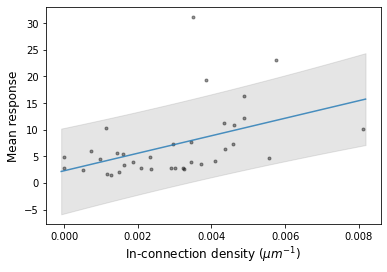

r = 0.4569638381195226, p = 0.0050829630961622095


In [221]:
xval = inconn_density[tune_all_idx]
yval = mean_response[tune_all_idx]

Xval = sm.add_constant(xval)
re = sm.OLS(yval, Xval).fit()

xrng = np.max(xval) - np.min(xval)
xlin = np.linspace(np.min(xval)-0.01*xrng,np.max(xval)+0.01*xrng,100)
Xlin = sm.add_constant(xlin)
dt = re.get_prediction(Xlin).summary_frame(alpha = 0.2)

plt.figure()
plt.plot(xval, yval, 'k.', alpha=0.4)
plt.plot(xlin, dt["mean"], '-', alpha=0.8)
plt.fill_between(
        xlin, dt["obs_ci_lower"], dt["obs_ci_upper"],
        alpha=0.2, color="gray")
plt.xlabel("In-connection density ($\mu m^{-1}$)", fontsize=12)
plt.ylabel("Mean response", fontsize=12)
plt.show()

r,p = pearsonr(xval, yval)
print("r = {}, p = {}".format(r,p))

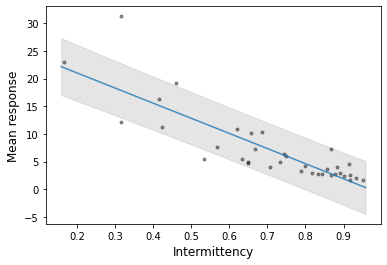

r = -0.8447827046888382, p = 9.302368010321629e-11


In [265]:
xval = intermittency[tune_all_idx]
yval = mean_response[tune_all_idx]

Xval = sm.add_constant(xval)
re = sm.OLS(yval, Xval).fit()

xrng = np.max(xval) - np.min(xval)
xlin = np.linspace(np.min(xval)-0.01*xrng,np.max(xval)+0.01*xrng,100)
Xlin = sm.add_constant(xlin)
dt = re.get_prediction(Xlin).summary_frame(alpha = 0.2)

plt.figure()
plt.plot(xval, yval, 'k.', alpha=0.4)
plt.plot(xlin, dt["mean"], '-', alpha=0.8)
plt.fill_between(
        xlin, dt["obs_ci_lower"], dt["obs_ci_upper"],
        alpha=0.2, color="gray")
plt.xlabel("Intermittency", fontsize=12)
plt.ylabel("Mean response", fontsize=12)
plt.show()

r,p = pearsonr(xval, yval)
print("r = {}, p = {}".format(r,p))

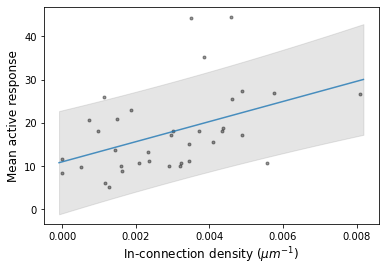

r = 0.4404643763241473, p = 0.007177090906683019


In [222]:
xval = inconn_density[tune_all_idx]
yval = mean_active_response[tune_all_idx]

Xval = sm.add_constant(xval)
re = sm.OLS(yval, Xval).fit()

xrng = np.max(xval) - np.min(xval)
xlin = np.linspace(np.min(xval)-0.01*xrng,np.max(xval)+0.01*xrng,100)
Xlin = sm.add_constant(xlin)
dt = re.get_prediction(Xlin).summary_frame(alpha = 0.2)

plt.figure()
plt.plot(xval, yval, 'k.', alpha=0.4)
plt.plot(xlin, dt["mean"], '-', alpha=0.8)
plt.fill_between(
        xlin, dt["obs_ci_lower"], dt["obs_ci_upper"],
        alpha=0.2, color="gray")
plt.xlabel("In-connection density ($\mu m^{-1}$)", fontsize=12)
plt.ylabel("Mean active response", fontsize=12)
plt.show()

r,p = pearsonr(xval, yval)
print("r = {}, p = {}".format(r,p))

## Intermittency is related to degree

In [226]:
def compute_intermittency(spike, condition, pref_idx, thr=3):
    
    spike = spike*(spike>=thr*np.std(spike))
    
    valid = ~np.isnan(condition)
    angle_list = np.unique(condition[valid])
    
    trial_arr = np.ones((16,30))*np.nan
    for i in range(angle_list.shape[0]):
        
        angle = angle_list[i]
        section_list = get_section(condition, angle)

        for j in range(len(section_list)):

            s = section_list[j]

            spike_section = spike[s[0]:s[1]]
            if np.sum(spike_section) > 0:
                trial_arr[i,j] = 0
            else:
                trial_arr[i,j] = 1
    
    frac_angle = np.nansum(trial_arr, axis=1)/np.sum(~np.isnan(trial_arr), axis=1) 
    
    return np.mean(frac_angle[pref_idx])

In [227]:
intermittency = np.zeros(n_func)
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    scan_id = int(scan_list[pyc_func_list==seg_id])

    trace = Trace[seg_id]
    spike = Spike[seg_id]
    stimlab = StimulusLabel["scan{}".format(scan_id)]
    
    response_array = get_peakamp_tdarray(trace, stimlab)
    u, s, vh = np.linalg.svd(response_array, full_matrices=False)
    resp_dir = np.abs(vh[0,:])
    resp_t = np.abs(u[:,0])
    
    pref_idx = np.where(resp_dir>np.mean(resp_dir))[0]
    intermittency[i] = compute_intermittency(spike, stimlab, pref_idx, thr=3)

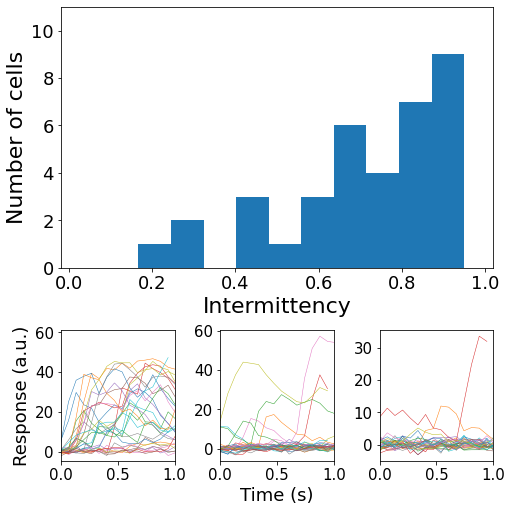

In [255]:
fig = plt.figure(figsize=(7,7), constrained_layout=True)
gs = fig.add_gridspec(6,6)

ax1 = fig.add_subplot(gs[:4,:6])
h = ax1.hist(intermittency[tune_all_idx], bins=10)
ax1.set_xlim(-0.02, 1.02)
ax1.set_ylim(0,11)
ax1.set_xticklabels(np.round(ax1.get_xticks(),1), fontsize=18, fontname="Helvetica")
ax1.set_yticklabels(ax1.get_yticks().astype("int"), fontsize=18, fontname="Helvetica")
ax1.set_xlabel("Intermittency", fontsize=22, fontname="Helvetica")
ax1.set_ylabel("Number of cells", fontsize=22, fontname="Helvetica")

# Example cells
ax2 = fig.add_subplot(gs[4:6,:2])
plot_trace_dir(ax2, 648518346349537961, 315, xlab="", ylab="Response (a.u.)")
ylim = list(ax2.get_ylim())
ylim[1] = 61
ax2.set_ylim(ylim)

ax3 = fig.add_subplot(gs[4:6,2:4])
plot_trace_dir(ax3, 648518346349532006, 180, xlab="Time (s)")

ax4 = fig.add_subplot(gs[4:6,4:6])
plot_trace_dir(ax4, 648518346349539834, 270, xlab="")

plt.savefig("figures/fig6_plots_part1.svg")
plt.show()

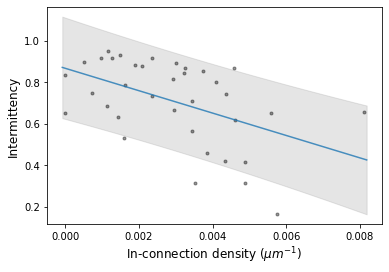

r = -0.485167169914788, p = 0.002707313286705971


In [224]:
xval = inconn_density[tune_all_idx]
yval = intermittency[tune_all_idx]

Xval = sm.add_constant(xval)
re = sm.OLS(yval, Xval).fit()

xrng = np.max(xval) - np.min(xval)
xlin = np.linspace(np.min(xval)-0.01*xrng,np.max(xval)+0.01*xrng,100)
Xlin = sm.add_constant(xlin)
dt = re.get_prediction(Xlin).summary_frame(alpha = 0.2)

plt.figure()
plt.plot(xval, yval, 'k.', alpha=0.4)
plt.plot(xlin, dt["mean"], '-', alpha=0.8)
plt.fill_between(
        xlin, dt["obs_ci_lower"], dt["obs_ci_upper"],
        alpha=0.2, color="gray")
plt.xlabel("In-connection density ($\mu m^{-1}$)", fontsize=12)
plt.ylabel("Intermittency", fontsize=12)
plt.show()

r,p = pearsonr(xval, yval)
print("r = {}, p = {}".format(r,p))

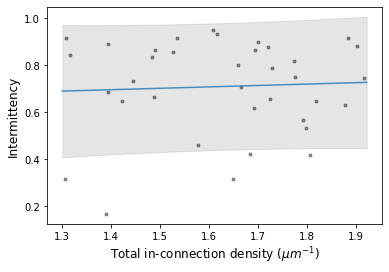

r = 0.053436859246335885, p = 0.7569206031598172


In [230]:
xval = total_insyn_dens[tune_all_idx]
yval = intermittency[tune_all_idx]

Xval = sm.add_constant(xval)
re = sm.OLS(yval, Xval).fit()

xrng = np.max(xval) - np.min(xval)
xlin = np.linspace(np.min(xval)-0.01*xrng,np.max(xval)+0.01*xrng,100)
Xlin = sm.add_constant(xlin)
dt = re.get_prediction(Xlin).summary_frame(alpha = 0.2)

plt.figure()
plt.plot(xval, yval, 'k.', alpha=0.4)
plt.plot(xlin, dt["mean"], '-', alpha=0.8)
plt.fill_between(
        xlin, dt["obs_ci_lower"], dt["obs_ci_upper"],
        alpha=0.2, color="gray")
plt.xlabel("Total in-connection density ($\mu m^{-1}$)", fontsize=12)
plt.ylabel("Intermittency", fontsize=12)
plt.show()

r,p = pearsonr(xval, yval)
print("r = {}, p = {}".format(r,p))

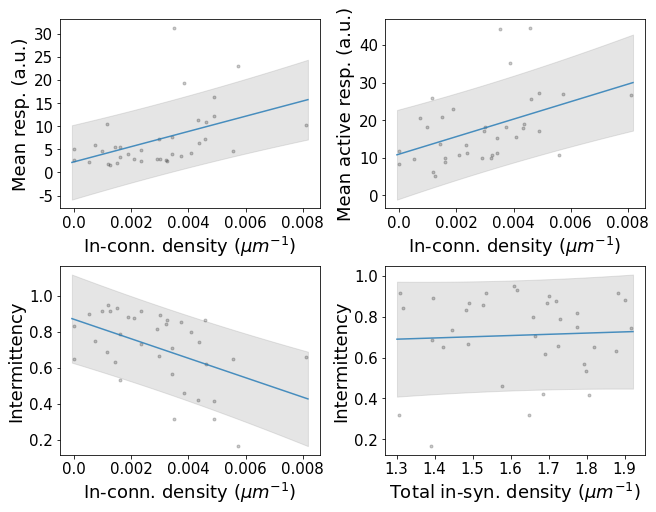

In [240]:
fig = plt.figure(figsize=(9,7), constrained_layout=True)
gs = fig.add_gridspec(6,6)

ax5 = fig.add_subplot(gs[:3,:3])
plot_linfit(ax5, inconn_density[tune_all_idx], mean_response[tune_all_idx], xlab="In-conn. density ($\mu m^{-1}$)", ylab="Mean resp. (a.u.)")
ax5.set_xticklabels(np.round(ax5.get_xticks(),3), fontsize=15, fontname="Helvetica")
ax5.set_yticklabels(ax5.get_yticks().astype("int"), fontsize=15, fontname="Helvetica")

ax6 = fig.add_subplot(gs[:3,3:6])
plot_linfit(ax6, inconn_density[tune_all_idx], mean_active_response[tune_all_idx], xlab="In-conn. density ($\mu m^{-1}$)", ylab="Mean active resp. (a.u.)")
ax6.set_xticklabels(np.round(ax6.get_xticks(),3), fontsize=15, fontname="Helvetica")
ax6.set_yticklabels(ax6.get_yticks().astype("int"), fontsize=15, fontname="Helvetica")
    
ax7 = fig.add_subplot(gs[3:,:3])
plot_linfit(ax7, inconn_density[tune_all_idx], intermittency[tune_all_idx], xlab="In-conn. density ($\mu m^{-1}$)", ylab="Intermittency")
ax7.set_xticklabels(np.round(ax7.get_xticks(),3), fontsize=15, fontname="Helvetica")
ax7.set_yticklabels(np.round(ax7.get_yticks(),1), fontsize=15, fontname="Helvetica")

ax8 = fig.add_subplot(gs[3:,3:6])
plot_linfit(ax8, total_insyn_dens[tune_all_idx], intermittency[tune_all_idx], xlab="Total in-syn. density ($\mu m^{-1}$)", ylab="Intermittency")
ax8.set_xticklabels(np.round(ax8.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax8.set_yticklabels(np.round(ax8.get_yticks(),1), fontsize=15, fontname="Helvetica")

plt.savefig("figures/fig6_plots_part2.svg")
plt.show()

## Permutation test while restricting spatial location

In [337]:
xloc = pyc_func_soma_loc[tune_all_idx,0]
yloc = pyc_func_soma_loc[tune_all_idx,1]
zloc = pyc_func_soma_loc[tune_all_idx,2]

xbins = np.linspace(np.min(xloc), np.max(xloc)*1.001, 3); nx = xbins.shape[0]-1
ybins = np.linspace(np.min(yloc), np.max(yloc)*1.001, 5); ny = ybins.shape[0]-1
zbins = np.linspace(np.min(zloc), np.max(zloc)*1.001, 3); nz = zbins.shape[0]-1

val_density = inconn_density[tune_all_idx]
indices = np.arange(val_density.shape[0])

idx_list = []
density_list = []
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            
            valid = (xloc>=xbins[i])*(xloc<xbins[i+1]) \
                    *(yloc>=ybins[j])*(yloc<ybins[j+1]) \
                    *(zloc>=zbins[k])*(zloc<zbins[k+1])
            
            density_bin = val_density[valid]
            
            idx_list.append(indices[valid])
            density_list.append(density_bin)

### Mean response

In [328]:
xval = mean_response[tune_all_idx]
yval = inconn_density[tune_all_idx]

T = 10000
rand_resp = np.zeros((T,))

for t in range(T):
    
    density_shuffled = np.copy(xval)
    for j in range(len(idx_list)):
        idx_bin = idx_list[j]
        np.random.shuffle(density_list[j])
        density_shuffled[idx_bin] = density_list[j]
    
    r, p = pearsonr(xval, density_shuffled)
    rand_resp[t] = r

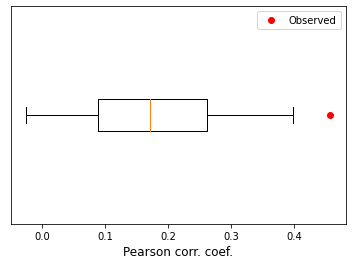

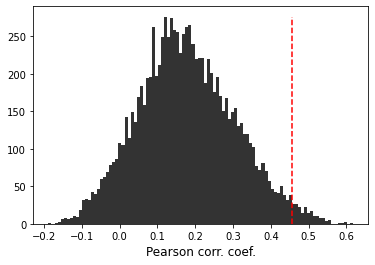

p = 0.019100000000000006


In [329]:
r_true_resp, p_true_resp = pearsonr(inconn_density[tune_all_idx], mean_response[tune_all_idx])

plt.figure()
plt.boxplot(rand_resp, sym="", whis=[5,95], vert=False)
plt.plot(r_true_resp, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_resp, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_resp, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

print("p = {}".format(1-percentileofscore(rand_resp, r_true_resp)/100))

### Mean active response

In [330]:
xval = mean_active_response[tune_all_idx]
yval = inconn_density[tune_all_idx]

T = 10000
rand_act_resp = np.zeros((T,))

for t in range(T):
    
    density_shuffled = np.copy(xval)
    for j in range(len(idx_list)):
        idx_bin = idx_list[j]
        np.random.shuffle(density_list[j])
        density_shuffled[idx_bin] = density_list[j]
    
    r, p = pearsonr(xval, density_shuffled)
    rand_act_resp[t] = r

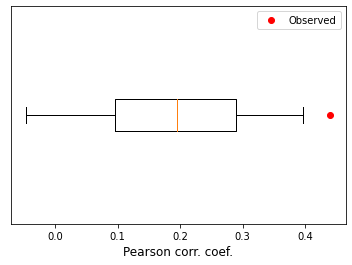

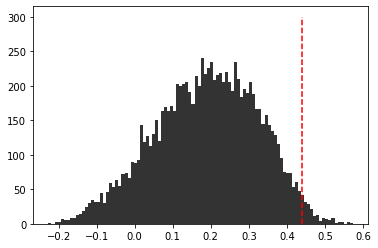

p = 0.01739999999999997


In [331]:
r_true_act_resp, p_true_act_resp = pearsonr(inconn_density[tune_all_idx], mean_active_response[tune_all_idx])

plt.figure()
plt.boxplot(rand_act_resp, sym="", whis=[5,95], vert=False)
plt.plot(r_true_act_resp, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_act_resp, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_act_resp, 0, 300, linestyle="--", color="r")
plt.show()

print("p = {}".format(1-percentileofscore(rand_act_resp, r_true_act_resp)/100))

### Intermittency

In [332]:
xval = intermittency[tune_all_idx]
yval = inconn_density[tune_all_idx]

T = 10000
rand_int = np.zeros((T,))

for t in range(T):
    
    density_shuffled = np.copy(xval)
    for j in range(len(idx_list)):
        idx_bin = idx_list[j]
        np.random.shuffle(density_list[j])
        density_shuffled[idx_bin] = density_list[j]
    
    r, p = pearsonr(xval, density_shuffled)
    rand_int[t] = r

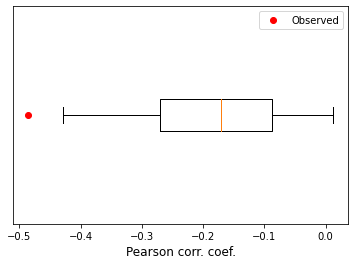

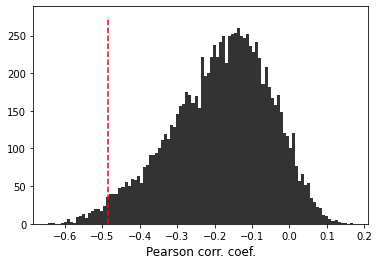

p = 0.018000000000000002


In [333]:
r_true_int, p_true_int = pearsonr(inconn_density[tune_all_idx], intermittency[tune_all_idx])

plt.figure()
plt.boxplot(rand_int, sym="", whis=[5,95], vert=False)
plt.plot(r_true_int, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_int, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_int, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

print("p = {}".format(percentileofscore(rand_int, r_true_int)/100))

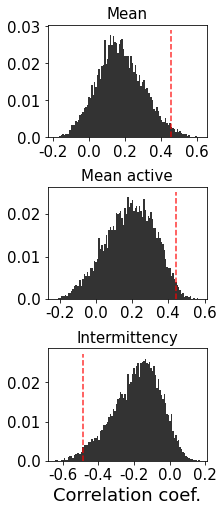

In [334]:
fig = plt.figure(figsize=(3,7), constrained_layout=True)
gs = fig.add_gridspec(3,1)

ax9 = fig.add_subplot(gs[:1,0])
ax9.hist(rand_resp, bins=100, color="k", alpha=0.8)
ax9.vlines(r_true_resp, ax9.get_ylim()[0], ax9.get_ylim()[1], color="r", linestyle="--", alpha=0.8)
ax9.set_xticklabels(np.round(ax9.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax9.set_yticklabels(np.round((ax9.get_yticks()/10000),2), fontsize=15, fontname="Helvetica")
ax9.set_title("Mean", fontsize=15, fontname="Helvetica")

ax10 = fig.add_subplot(gs[1:2,0])
ax10.hist(rand_act_resp, bins=100, color="k", alpha=0.8)
ax10.vlines(r_true_act_resp, ax10.get_ylim()[0], ax10.get_ylim()[1], color="r", linestyle="--", alpha=0.8)
ax10.set_xticklabels(np.round(ax10.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax10.set_yticklabels(np.round((ax10.get_yticks()/10000),2), fontsize=15, fontname="Helvetica")
ax10.set_title("Mean active", fontsize=15, fontname="Helvetica")

ax11 = fig.add_subplot(gs[2:,0])
ax11.hist(rand_int, bins=100, color="k", alpha=0.8)
ax11.vlines(r_true_int, ax11.get_ylim()[0], ax11.get_ylim()[1], color="r", linestyle="--", alpha=0.8)
ax11.set_xticklabels(np.round(ax11.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax11.set_yticklabels(np.round((ax11.get_yticks()/10000),2), fontsize=15, fontname="Helvetica")
ax11.set_xlabel("Correlation coef.", fontsize=18, fontname="Helvetica")
ax11.set_title("Intermittency", fontsize=15, fontname="Helvetica")

plt.savefig("figures/fig6_plots_restricted_perm.svg")
plt.show()

## Permutation test

### Mean response

In [243]:
xval = mean_response[tune_all_idx]
yval = inconn_density[tune_all_idx]

T = 10000
rand_resp = np.zeros((T,))
for t in range(T):
    
    resp_shuffled = np.copy(xval)
    np.random.shuffle(resp_shuffled)
    
    r, p = pearsonr(resp_shuffled, yval)
    rand_resp[t] = r

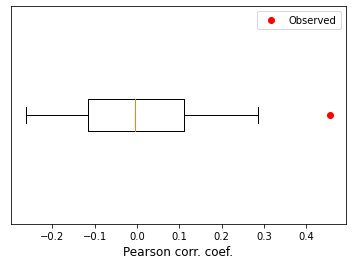

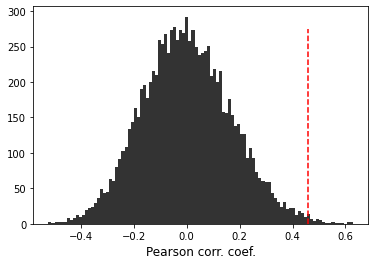

p = 0.004899999999999904


In [249]:
r_true_resp, p_true_resp = pearsonr(inconn_density[tune_all_idx], mean_response[tune_all_idx])

plt.figure()
plt.boxplot(rand_resp, sym="", whis=[5,95], vert=False)
plt.plot(r_true_resp, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_resp, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_resp, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

print("p = {}".format(1-percentileofscore(rand_resp, r_true_resp)/100))

### Mean active response

In [250]:
xval = mean_active_response[tune_all_idx]
yval = inconn_density[tune_all_idx]

T = 10000
rand_act_resp = np.zeros((T,))
for t in range(T):
    
    resp_shuffled = np.copy(xval)
    np.random.shuffle(resp_shuffled)
    
    r, p = pearsonr(resp_shuffled, yval)
    rand_act_resp[t] = r

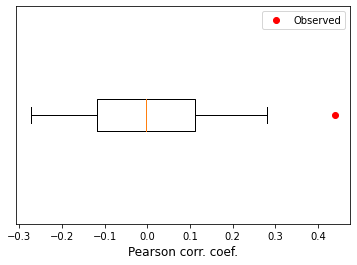

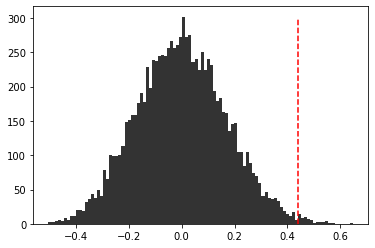

p = 0.006099999999999994


In [251]:
r_true_act_resp, p_true_act_resp = pearsonr(inconn_density[tune_all_idx], mean_active_response[tune_all_idx])

plt.figure()
plt.boxplot(rand_act_resp, sym="", whis=[5,95], vert=False)
plt.plot(r_true_act_resp, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_act_resp, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_act_resp, 0, 300, linestyle="--", color="r")
plt.show()

print("p = {}".format(1-percentileofscore(rand_act_resp, r_true_act_resp)/100))

### Intermittency

In [252]:
xval = intermittency[tune_all_idx]
yval = inconn_density[tune_all_idx]

T = 10000
rand_int = np.zeros((T,))
for t in range(T):
    
    int_shuffled = np.copy(xval)
    np.random.shuffle(int_shuffled)
    
    r, p = pearsonr(int_shuffled, yval)
    rand_int[t] = r

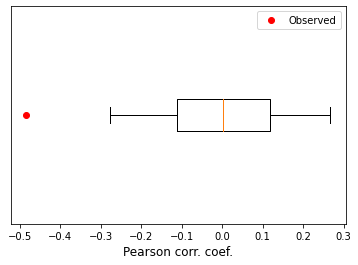

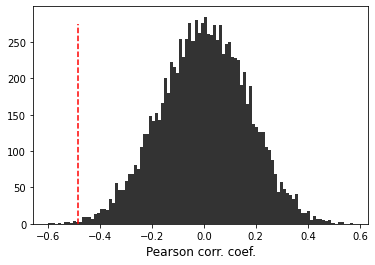

p = 0.0014000000000000002


In [253]:
r_true_int, p_true_int = pearsonr(inconn_density[tune_all_idx], intermittency[tune_all_idx])

plt.figure()
plt.boxplot(rand_int, sym="", whis=[5,95], vert=False)
plt.plot(r_true_int, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_int, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_int, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

print("p = {}".format(percentileofscore(rand_int, r_true_int)/100))

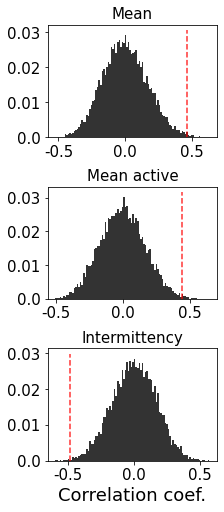

In [254]:
fig = plt.figure(figsize=(3,7), constrained_layout=True)
gs = fig.add_gridspec(3,1)

ax9 = fig.add_subplot(gs[:1,0])
ax9.hist(rand_resp, bins=100, color="k", alpha=0.8)
ax9.vlines(r_true_resp, ax9.get_ylim()[0], ax9.get_ylim()[1], color="r", linestyle="--", alpha=0.8)
ax9.set_xticklabels(np.round(ax9.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax9.set_yticklabels(np.round((ax9.get_yticks()/10000),2), fontsize=15, fontname="Helvetica")
ax9.set_title("Mean", fontsize=15, fontname="Helvetica")

ax10 = fig.add_subplot(gs[1:2,0])
ax10.hist(rand_act_resp, bins=100, color="k", alpha=0.8)
ax10.vlines(r_true_act_resp, ax10.get_ylim()[0], ax10.get_ylim()[1], color="r", linestyle="--", alpha=0.8)
ax10.set_xticklabels(np.round(ax10.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax10.set_yticklabels(np.round((ax10.get_yticks()/10000),2), fontsize=15, fontname="Helvetica")
ax10.set_title("Mean active", fontsize=15, fontname="Helvetica")

ax11 = fig.add_subplot(gs[2:,0])
ax11.hist(rand_int, bins=100, color="k", alpha=0.8)
ax11.vlines(r_true_int, ax11.get_ylim()[0], ax11.get_ylim()[1], color="r", linestyle="--", alpha=0.8)
ax11.set_xticklabels(np.round(ax11.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax11.set_yticklabels(np.round((ax11.get_yticks()/10000),2), fontsize=15, fontname="Helvetica")
ax11.set_xlabel("Correlation coef.", fontsize=18, fontname="Helvetica")
ax11.set_title("Intermittency", fontsize=15, fontname="Helvetica")

plt.savefig("figures/fig6_plots_part3.svg")
plt.show()